# STOP MAKE SURE YOU HAVE DONE THE FOLLOWING BEFORE RUNNING THIS WORKBOOK

1. Make sure that you have the NIST data on your computer
2. You need to have a target file from the processed InChi Keys
3. Convert your data to csv files

First Call in all of your Imports

In [1]:
#IMPORTS 
import os
import sys
import glob
import pandas as pd
import numpy as np
import csv
from csv import writer
from csv import reader
import matplotlib.pyplot as plt
import random
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# The following will allow us to cycle through all of the different functional groups so we don't have to write things 20 times

In [2]:
top_dir = ['nitrile','ketone','ether','ester','carboxylic_acid','aromatic','amine','amide','alkyne','alkane','alkene','alcohol','nitro','alkyl_halide','acyl_halide','methyl','aldehyde','n_containing', 'o_containing', 'a_containing']
#Hold = []
func_groups = ['nitrile','ketone','ether','ester','carboxylic_acid','aromatic',
              'amine','amide','alkyne','alkane','alkene','alcohol',
              'nitro','alkyl_halide','acyl_halide','methyl','aldehyde', 'n_containing', 'o_containing', 'a_containing',
              'not_nitrile','not_ketone','not_ether','not_ester','not_carboxylic_acid','not_aromatic',
              'not_amine','not_amide','not_alkyne','not_alkane','not_alkene','not_alcohol',
              'not_nitro','not_alkyl_halide','not_acyl_halide','not_methyl','not_aldehyde', 'not_n_containing', 'not_o_containing', 'not_a_containing']

In [3]:
path = r'PATH'

# Now we need to pull in all of the csv files and create a data frame of all of the mass spectra to be sorted later (the ones without the added 0s)

In [4]:
#This is where your data is coming from and going to
#possibly change paths to inputs
#path = input("Enter path here")
data_path = path + '\\' +'Full_Dataset'
#The following lines will find all of the files of a given type in the path's folder
extension = 'csv'
os.chdir(path)
result = glob.glob('*.{}'.format(extension))
#Here are the files that fit your criterion that are within the path file
all_files = glob.glob(path + "/*.csv")

# Section 1: Preprocessing CSV files

Currently the top row of each has x and y as the column headers I need to remove the y and replace it with the CAS number so that I can call on the column headers later - ONLY NEEDS TO BE DONE ONCE

In [5]:
#for filename in all_files:
#    #Need to separate the CAS from the filename
#    path= r"F:\NIST_MS\GH_Method\candiy_spectrum-master\Data\csv"
#    cas = filename.replace(path,'')
#    cas = cas.replace('\\','')
#    cas = cas.replace('.csv','')
#    print(cas)
#    df = pd.read_csv(filename, index_col=False, header=0)
#    df = df.rename(columns = {'y':cas})
#    with open(filename, 'w', newline='') as file:
#        writer = csv.writer(file, delimiter = ',')
#        writer.writerow(('mass', cas))
#        writer.writerows(zip(df['x'],df[cas]) )
#    if not  file.closed:
#        file.close()

Next we ensure that all of the entries in the target file are 1 or 0. 1 indicating the presence of that functional group, 0 indicating the absense. We also need to remove and CAS numbers that have InChi Keys but do not have mass spectra on the NIST website

In [6]:
# read in target
target_file=path + '\\' + 'target.csv'
target = pd.read_csv(target_file)
#Change non 1 numbers to 1
for f in top_dir:
    target.loc[target[f] != 0, f] = 1 
#Remove CAS that do not have csv files
for i in range(len(target)):
    n = target.loc[i,"cas"]
    source =data_path
    kind = ".csv"
    path =str(source)+str("\\")+str(n)+kind
    if not os.path.exists(str(path)):
        target = target.drop(i, axis=0)
target= target.reset_index()
#take a peek and make sure it looks correct
target.head()

,index,cas,alkane,methyl,alkene,alkyne,alcohol,amine,nitrile,aromatic,...,ketone,aldehyde,carboxylic_acid,ether,acyl_halide,amide,nitro,n_containing,o_containing,a_containing
0,1,100016,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,1,1,1,1
1,2,100027,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,1,1,1,1
2,4,1000493,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8,100061,0,1,0,0,0,0,0,1,...,1,0,0,1,0,0,0,0,1,1
4,12,100072,0,1,0,0,0,0,0,1,...,0,0,0,1,1,0,0,0,1,1


# Section 2: Creating the Master Data Frame with all of the Mass spectra and all of the InChi Key Identifiers

So now in the process, we have csv files that are labeled with their respective CAS number both in the file name as well as in the y axis column title. Now we can work to create data frames that have the masses in the first column then all following spectra titled with their CAS number

First we will define the process by making one data frame with all of the spectra contained in it.

This is also the code block in which you can adjust the mass range of interest and what should happen to missing data points. We also average the spectra in this block.

In [7]:
#NIST Spectra
all_spectra = pd.DataFrame()
for i in range(len(target)):
    f = target.loc[i,"cas"]
    path = data_path
    filename = str(f) + ".csv"
    path_i = path + "\\" + filename
    #double check that the file exists
    if os.path.exists(path_i) == True:
        #pull in the columns of data into a dataframe
        hold = pd.read_csv(path_i, header = 0)
        mass = hold.iloc[:,0].tolist()
        y = hold.iloc[:,1].tolist()
        #we need to normalize y before continuing
        y_max = max(y)
        y_2 = [y/y_max for y in y]
        #Counter allows you to choose the mass range of interest
        counter=list(range(1,302))
        #y_fill is what all of the unlisted values will be taken in as.
        y_fill = 0
        #The next for statement will add in lines for missing mass values
        for i in counter:
            if i not in mass:
                mass.append(i)
                y_2.append(y_fill)
        spectrum = zip(mass, y_2)
        spectrum = sorted(spectrum, key = lambda x: x[0]) 
        spectrum = pd.DataFrame(spectrum, columns=['mass', f])
        #print(spectrum[f])
        all_spectra[f] = spectrum[f]

Now we need to look at the top rows for both the all_spectra and the target to see if they can be combined as is or if we need to do further processing before combining them.

In [8]:
all_spectra.head()

,100016,100027,1000493,100061,100072,1000868,1000879,100094,100107,10010932,...,999553,99960095,999644,99967,99978,999780,99989,99990,999906,999973
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
target.head()

,index,cas,alkane,methyl,alkene,alkyne,alcohol,amine,nitrile,aromatic,...,ketone,aldehyde,carboxylic_acid,ether,acyl_halide,amide,nitro,n_containing,o_containing,a_containing
0,1,100016,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,1,1,1,1
1,2,100027,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,1,1,1,1
2,4,1000493,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8,100061,0,1,0,0,0,0,0,1,...,1,0,0,1,0,0,0,0,1,1
4,12,100072,0,1,0,0,0,0,0,1,...,0,0,0,1,1,0,0,0,1,1


As we can see these DO NOT match. The all_spectra data frame has the CAS numbers running across the columns whereas the target has them going down the rows. In order to call on areas of data for training later the CAS numbers need to be going the same direction. I chose to make the CAS numbers into the rows so that I could call on the columns for doing my feature analysis. The following code block uses the transpose function to flip the rows and columns. It also resets the index from before so that both the all_spectra and target dataframes can be called on and compared by their index.

In [10]:
all_spectra_t = all_spectra.transpose()
all_spectra_t = all_spectra_t.reset_index()

Now we can look and ensure that the columns and rows of the all_spectra data frame have been flipped to make all_spectra_t.

In [11]:
all_spectra_t.head()

,index,0,1,2,3,4,5,6,7,8,...,291,292,293,294,295,296,297,298,299,300
0,100016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1000493,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100061,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100072,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The purpose of this next block is to ensure that all of the CAS numbers line up in with all_spectra dataframe as well as the target data frame. Due to the fact that they read into Python in the order that they exist in the file on the computer and the fact that we have removed all CAS numbers that do not have a respective CSV file this should always be true. If the next block outputs the string "bad" something got screwed up earlier in this worbook.

In [12]:
for i in range(len(target)):
    if target.loc[i, 'cas'] != all_spectra_t.loc[i, 'index']:
        print("bad")

Now that we know the indices line up properly for both data frames we can combine them into one large data frame. That is what this next block does.

In [13]:
for i in top_dir:
    all_spectra_t[i] = target[i]

We can also switch our index to be the cas number column (called "index" in this case) to make calling the rows much easier later as we now know that the indexes match and we have sucessfully combined the data frames.

We can also look at the header of the of the all_spectra_t data frame and we should see columns corresponding to all of the masses that we specified earlier as well as 20 other columns one corresponding to each of the different target functional group classifications.

In [14]:
all_spectra_t.set_index('index', inplace=True)

# Section 3: Organize CAS numbers into Lists for the Training and Testing of Each Functional Group Classification

First we need to make empty lists to contain all of the CAS numbers that we will have for each functional group. There are 4 kinds of lists that we are making.

li = These will contain the positive case (functional group is present)

t li = This will contain 10 random CAS numbers from the li_ list for testing the model after training

li not = These will contain the negative case (functional group is absent)

t not li = This will contain 10 random CAS numbers from the li_not list for testing the model after training

li tot = This will eventually contain all of the CAS numbers for the positive and negative cases together

There will also be a list later of specific CAS numbers selected as molecules of interest to do a final model validation on all 20 models later.

In [15]:
#Create Lists to catch CAS numbers

li_acyl_halide = []
t_acyl_halide = []
li_not_acyl_halide = []
t_not_acyl_halide = []

li_alcohol = []
t_alcohol = []
li_not_alcohol = []
t_not_alcohol = []

li_aldehyde = []
t_aldehyde = []
li_not_aldehyde = []
t_not_aldehyde = []

li_alkane = []
t_alkane = []
li_not_alkane = []
t_not_alkane = []
li_tot_alkane = []

li_alkene = []
t_alkene = []
li_not_alkene = []
t_not_alkene = []

li_alkyl_halide = []
t_alkyl_halide = []
li_not_alkyl_halide = []
t_not_alkyl_halide = []

li_alkyne =  []
t_alkyne =  []
li_not_alkyne =  []
t_not_alkyne =  []

li_amide = []
t_amide = []
li_not_amide = []
t_not_amide = []

li_amine = []
t_amine = []
li_not_amine = []
t_not_amine = []

li_aromatic = []
t_aromatic = []
li_not_aromatic = []
t_not_aromatic = []

li_carboxylic_acid = []
t_carboxylic_acid = []
li_not_carboxylic_acid = []
t_not_carboxylic_acid = []

li_ester = []
t_ester = []
li_not_ester = []
t_not_ester = []

li_ether = []
t_ether = []
li_not_ether = []
t_not_ether = []

li_ketone = []
t_ketone = []
li_not_ketone = []
t_not_ketone = []

li_methyl = []
t_methyl = []
li_not_methyl = []
t_not_methyl = []

li_nitrile = []
t_nitrile = []
li_not_nitrile = []
t_not_nitrile = []

li_nitro = []
t_nitro = []
li_not_nitro = []
t_not_nitro = []

li_n_containing = []
t_n_containing = []
li_not_n_containing = []
t_not_n_containing = []

li_o_containing = []
t_o_containing = []
li_not_o_containing = []
t_not_o_containing = []

li_a_containing  = []
t_a_containing  = []
li_not_a_containing  = []
t_not_a_containing  = []

The following block will take all of the cas numbers and assign them to the positive or negative case for each functional group classification

In [16]:
for l in top_dir:
    for i in range(len(target)):
        source = data_path
        kind = ".csv"
        f=str(source)+str("\\")+str(target.loc[i,"cas"])+kind
        if os.path.exists(str(f)):
            if target.loc[i,l] != 0: 
                locals()["li_"+str(l)].append(target.loc[i,"cas"])
            if not target.loc[i,l]:
                locals()["li_not_"+str(l)].append(target.loc[i,"cas"])

In [17]:
distributions = []
for l in top_dir:
    print(l)
    print(len(locals()["li_"+str(l)]))
    distributions.append(len(locals()["li_"+str(l)]))
labeled_distributions = list(zip(top_dir, distributions))
labeled_distributions = pd.DataFrame(labeled_distributions)
labeled_distributions.to_csv(path + '\\' + 'distrubutions.csv')

nitrile
605
ketone
1773
ether
5416
ester
2878
carboxylic_acid
1091
aromatic
10463
amine
2000
amide
396
alkyne
394
alkane
14963
alkene
3750
alcohol
4927
nitro
858
alkyl_halide
4486
acyl_halide
179
methyl
14274
aldehyde
452
n_containing
3610
o_containing
11651
a_containing
10463


Now we need to check if all of the positive and negative cases sum up properly. We can do this by taking the sum of the positive and negative cases for each functional group. Because every possible CAS number either has or does not have each functional group all of these should sum to the total number of CSV files we have.

In [18]:
for l in top_dir:
    print(str(l)+ "   " + str(len(locals()["li_"+str(l)])+len(locals()["li_not_"+str(l)])))

nitrile   21138
ketone   21138
ether   21138
ester   21138
carboxylic_acid   21138
aromatic   21138
amine   21138
amide   21138
alkyne   21138
alkane   21138
alkene   21138
alcohol   21138
nitro   21138
alkyl_halide   21138
acyl_halide   21138
methyl   21138
aldehyde   21138
n_containing   21138
o_containing   21138
a_containing   21138


 Now we remove the test files

IMPORTANT: The Random Kernel is important to ensure that the same numbers are pulled each time so that they are not represented in some training sets and not others. The random Kernel is based on the tracking number i, that is also being used to pull 10 numbers from each class. Because the length of each of the different lists is different this means that it will choose different place holder values from each set so there shouldn't be an introduced bias there but the same numbers will be chosen every time for each set!

This also allows us to choose the same test files so that we can compare properly to the inception model as well

In [19]:
#Remove Test numbers from sets
for l in top_dir:
    i=0
    m1 = len(locals()["li_"+str(l)])
    m2 = len(locals()["li_not_"+str(l)])
    while i<50:
        random.seed(i)
        rand_num_1=random.randint(0,m1-1)
        rand_num_2=random.randint(0,m2-1)
        move_1 = locals()["li_"+str(l)][rand_num_1]
        move_2 = locals()["li_not_"+str(l)][rand_num_2]
        locals()["t_"+str(l)].append(move_1)
        locals()["t_not_"+str(l)].append(move_2)
        locals()["li_"+str(l)].remove(move_1)
        locals()["li_not_"+str(l)].remove(move_2)
        i=i+1
        m1=m1-1
        m2=m2-1

In [20]:
len(li_not_acyl_halide)

20909

Now we need to even out the positive and negative cases.

To avoid a sampling bias the positive and negative cases need to have the same number of examples. The following code will randomly remove one from the larger class each time so that they will eventually be even. This random sampling changes with each iteration so if this code is run multiple times different data sets will be created. Proceed with caution.

In [21]:
#Even out remaining lists
for l in top_dir:
    difference = abs(len(locals()["li_"+str(l)])-len(locals()["li_not_"+str(l)]))
    while difference>0:
        if len(locals()["li_"+str(l)])>len(locals()["li_not_"+str(l)]):
            m1 = len(locals()["li_"+str(l)])
            #print(m1)
            rand_num_1=random.randint(0,m1-1)
            #print(rand_num_1>m1)
            move_1 = locals()["li_"+str(l)][rand_num_1]
            locals()["li_"+str(l)].remove(move_1)
        else:
            m2 = len(locals()["li_not_"+str(l)])
            rand_num_2=random.randint(0,m2-1)
            move_2 = locals()["li_not_"+str(l)][rand_num_2]
            locals()["li_not_"+str(l)].remove(move_2)
        difference = difference - 1

Check that they are even now

In [22]:
len(li_alcohol)==len(li_not_alcohol)

True

So we now have lists of CAS numbers for each functional group which are even for positive and negative cases and we know that none of the test files can be in the list that will then be used for the training and we have a massive data frame with all of the different CAS numbers in it. We can now create smaller data frames based on these lists. First we need to combine the CAS lists for the positive and negative case for each functional group so they can be pulled into the dataframe together.

In [23]:
#Nitrile
li_tot_nitrile = li_nitrile + li_not_nitrile
li_test_nitrile = t_nitrile + t_not_nitrile
#Ketone
li_tot_ketone = li_ketone + li_not_ketone
li_test_ketone = t_ketone + t_not_ketone
#Ether
li_tot_ether = li_ether + li_not_ether
li_test_ether = t_ether + t_not_ether
#Ester
li_tot_ester = li_ester + li_not_ester
li_test_ester = t_ester + t_not_ester
#Carboxylic Acid
li_tot_carboxylic_acid = li_carboxylic_acid + li_not_carboxylic_acid
li_test_carboxylic_acid = t_carboxylic_acid + t_not_carboxylic_acid
#Aromatic
li_tot_aromatic = li_aromatic + li_not_aromatic
li_test_aromatic = t_aromatic + t_not_aromatic
#Amine
li_tot_amine = li_amine + li_not_amine
li_test_amine = t_amine + t_not_amine
#Amide
li_tot_amide = li_amide + li_not_amide
li_test_amide = t_amide + t_not_amide
#Alkyne
li_tot_alkyne = li_alkyne + li_not_alkyne
li_test_alkyne = t_alkyne + t_not_alkyne
#Alkane
li_tot_alkane = li_alkane + li_not_alkane
li_test_alkane = t_alkane + t_not_alkane
#Alkene
li_tot_alkene = li_alkene + li_not_alkene
li_test_alkene = t_alkene + t_not_alkene
#Alcohol
li_tot_alcohol = li_alcohol + li_not_alcohol
li_test_alcohol = t_alcohol + t_not_alcohol
#Nitro
li_tot_nitro = li_nitro + li_not_nitro
li_test_nitro = t_nitro + t_not_nitro
#Akyl Halide
li_tot_alkyl_halide = li_alkyl_halide + li_not_alkyl_halide
li_test_alkyl_halide = t_alkyl_halide + t_not_alkyl_halide
#Acyl Halide
li_tot_acyl_halide = li_acyl_halide + li_not_acyl_halide
li_test_acyl_halide = t_acyl_halide + t_not_acyl_halide
#Methyl
li_tot_methyl = li_methyl + li_not_methyl
li_test_methyl = t_methyl + t_not_methyl
#Aldehyde
li_tot_aldehyde = li_aldehyde + li_not_aldehyde
li_test_aldehyde = t_aldehyde + t_not_aldehyde
#N Containing
li_tot_n_containing = li_n_containing + li_not_n_containing
li_test_n_containing = t_n_containing + t_not_n_containing
#O Containing
li_tot_o_containing = li_o_containing + li_not_o_containing
li_test_o_containing = t_o_containing + t_not_o_containing
#A Containing
li_tot_a_containing = li_a_containing + li_not_a_containing
li_test_a_containing = t_a_containing + t_not_a_containing
#specific examples - for final validation later
li_specific_examples = [73223, 71001, 74986, 74828]
li_experimental_examples = ['2Furanmethanol','Limonene','Pyridine']

So now that we have the lists of every CAS number (both for the positive and negative cases) we can call on those CAS numbers as the index for the all_spectra_t data frame. This will copy those lines over into the new data frame that will be named with "df_" and the functional group classification.

In [24]:
#Nitrile
df_nitrile = all_spectra_t.loc[li_tot_nitrile]
df_test_nitrile = all_spectra_t.loc[li_test_nitrile]
#Ketone
df_ketone = all_spectra_t.loc[li_tot_ketone]
df_test_ketone = all_spectra_t.loc[li_test_ketone]
#Ether
df_ether = all_spectra_t.loc[li_tot_ether]
df_test_ether = all_spectra_t.loc[li_test_ether]
#Ester
df_ester = all_spectra_t.loc[li_tot_ester]
df_test_ester = all_spectra_t.loc[li_test_ester]
#Carboxylic Acid
df_carboxylic_acid = all_spectra_t.loc[li_tot_carboxylic_acid]
df_test_carboxylic_acid = all_spectra_t.loc[li_test_carboxylic_acid]
#Aromatic
df_aromatic = all_spectra_t.loc[li_tot_aromatic]
df_test_aromatic = all_spectra_t.loc[li_test_aromatic]
#Amine
df_amine = all_spectra_t.loc[li_tot_amine]
df_test_amine = all_spectra_t.loc[li_test_amine]
#Amide
df_amide = all_spectra_t.loc[li_tot_amide]
df_test_amide = all_spectra_t.loc[li_test_amide]
#Alkyne
df_alkyne = all_spectra_t.loc[li_tot_alkyne]
df_test_alkyne = all_spectra_t.loc[li_test_alkyne]
#Alkane
df_alkane = all_spectra_t.loc[li_tot_alkane]
df_test_alkane = all_spectra_t.loc[li_test_alkane]
#Alkene
df_alkene = all_spectra_t.loc[li_tot_alkene]
df_test_alkene = all_spectra_t.loc[li_test_alkene]
#Alcohol
df_alcohol = all_spectra_t.loc[li_tot_alcohol]
df_test_alcohol = all_spectra_t.loc[li_test_alcohol]
#Nitro
df_nitro = all_spectra_t.loc[li_tot_nitro]
df_test_nitro = all_spectra_t.loc[li_test_nitro]
#Akyl Halide
df_alkyl_halide = all_spectra_t.loc[li_tot_alkyl_halide]
df_test_alkyl_halide = all_spectra_t.loc[li_test_alkyl_halide]
#Acyl Halide
df_acyl_halide = all_spectra_t.loc[li_tot_acyl_halide]
df_test_acyl_halide = all_spectra_t.loc[li_test_acyl_halide]
#Methyl
df_methyl = all_spectra_t.loc[li_tot_methyl]
df_test_methyl = all_spectra_t.loc[li_test_methyl]
#Aldehyde
df_aldehyde = all_spectra_t.loc[li_tot_aldehyde]
df_test_aldehyde = all_spectra_t.loc[li_test_aldehyde]
#N Containing
df_n_containing = all_spectra_t.loc[li_tot_n_containing]
df_test_n_containing = all_spectra_t.loc[li_test_n_containing]
#O Containing
df_o_containing = all_spectra_t.loc[li_tot_o_containing]
df_test_o_containing = all_spectra_t.loc[li_test_o_containing]
#A Containing
df_a_containing = all_spectra_t.loc[li_tot_a_containing]
df_test_a_containing = all_spectra_t.loc[li_test_a_containing]

#Specific Test Examples
tryptophan = all_spectra_t.loc[73223]
histidine = all_spectra_t.loc[71001]
propane = all_spectra_t.loc[74986]

df_specific_examples = all_spectra_t.loc[li_specific_examples]

experimental_spectra = pd.read_csv(path + '\\' +'experimental_spectra.csv')
df_experimental_samples = experimental_spectra[li_experimental_examples].T

In [25]:
masses = list(range(1,301))
df_o_containing[masses]

,1,2,3,4,5,6,7,8,9,10,...,291,292,293,294,295,296,297,298,299,300
index,,,,,,,,,,,,,,,,,,,,,
100016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100094,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
999780,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
df_experimental_samples[masses]

,1,2,3,4,5,6,7,8,9,10,...,291,292,293,294,295,296,297,298,299,300
2Furanmethanol,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Limonene,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Pyridine,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Section 5: Training an Array Based Model

The first model that we will attempt is a simple logistic regression using all of the mass values (no feature selection).

To do this, first we need to split the into dependent variables (does it have an alcohol) and the independent variables (the masses) then we can run each set with the LogisticRegression model from Sklearn

We also want to look at how the different solvers all approach this problem so we will make an array describing all of the results for each solver. I will include descriptions as to how each works. Quick reminder all of these approaches are working to minimize a loss function at their core.

### Newton-cg

This solver uses Newton's method from calculus. The method uses an iterative approach to finding the roots of a differentiable function (Where the function equals 0). This is normally applied to the first deriviative to show minima and maxima (or a saddle point in larger dimensions). This is becuase where the first deriviative is equal to 0 the inflection of the line is likely changing. This approach also uses the second deriviative describing the curvature to take a more direct path (red) to the minima than may be taken by simple gradient descent(green).

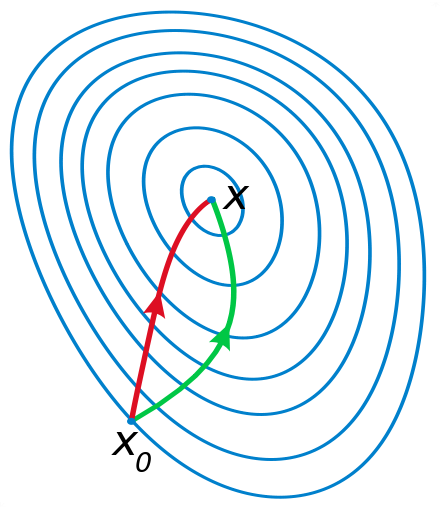

In [27]:
lr = LogisticRegression(max_iter=20000, solver ='newton-cg')

In [28]:
def interpet_model(FG,answer):
        if answer <= 0.5:
            print(FG + " Absent")
        else:
            print(FG + " Present")

In [30]:
file = path + '\\'+ 'Results'+"\\"+"LR_output.csv"
with open(file, 'w', newline='') as csvfile:
    
    fieldnames = ['FG All Masses', 'Training Accuracy','Testing Accuracy','Tryptophan','Histidine','Propane', 'Methane', 'Exp Furanmethanol', 'Exp Limonene', 'Exp Pyridine']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    masses = list(range(1,301))
    model_coefs = pd.DataFrame(masses, columns = ['masses'])

    #NIST TEST SET
    t_spec = df_specific_examples[masses]
    #EXPERIMENTAL TEST SET
    e_spec = df_experimental_samples[masses]
    
    #Nitrile
    model1 = lr
    y1 = df_nitrile['nitrile']
    x1 = df_nitrile[masses]
    y1t = df_test_nitrile['nitrile']
    x1t = df_test_nitrile[masses]
    model1.fit(x1, y1)
    y_pred_1 = model1.predict(x1t)
    y_pred_1_s = model1.predict(t_spec)
    e_pred_1 = model1.predict(e_spec)
    accuracy_1 = metrics.accuracy_score(y1t, y_pred_1)
    writer.writerow({'Exp Furanmethanol':e_pred_1[0], 'Exp Limonene':e_pred_1[1],'Exp Pyridine': e_pred_1[2], 'Methane':y_pred_1_s[3],'Tryptophan':y_pred_1_s[0], 'Histidine':y_pred_1_s[1], 'Propane':y_pred_1_s[2],'FG All Masses': 'Nitrile', 'Testing Accuracy': accuracy_1*100,'Training Accuracy': model1.score(x1,y1)*100 })
    model_coefs.insert(len(model_coefs.columns), 'nitrile',model1.coef_.T)

    #Ketone
    model2 = lr
    y2 = df_ketone['ketone']
    x2 = df_ketone[masses]
    y2t = df_test_ketone['ketone']
    x2t = df_test_ketone[masses]
    model2.fit(x2, y2)
    y_pred_2 = model2.predict(x2t)
    y_pred_2_s = model2.predict(t_spec)
    e_pred_2 = model2.predict(e_spec)
    accuracy_2 = metrics.accuracy_score(y2t, y_pred_2)
    writer.writerow({'Exp Furanmethanol':e_pred_2[0], 'Exp Limonene':e_pred_2[1],'Exp Pyridine': e_pred_2[2], 'Methane':y_pred_2_s[3],'Tryptophan':y_pred_2_s[0], 'Histidine':y_pred_2_s[1], 'Propane':y_pred_2_s[2],'FG All Masses': 'Ketone', 'Testing Accuracy': accuracy_2*100,'Training Accuracy': model2.score(x2,y2)*100 })
    model_coefs.insert(len(model_coefs.columns), 'ketone',model2.coef_.T)

    
    #ether
    model3 = lr
    y3 = df_ether['ether']
    x3 = df_ether[masses]
    y3t = df_test_ether['ether']
    x3t = df_test_ether[masses]
    model3.fit(x3, y3)
    y_pred_3 = model3.predict(x3t)
    y_pred_3_s = model3.predict(t_spec)
    e_pred_3 = model3.predict(e_spec)
    accuracy_3 = metrics.accuracy_score(y3t, y_pred_3)
    writer.writerow({'Exp Furanmethanol':e_pred_3[0], 'Exp Limonene':e_pred_3[1],'Exp Pyridine': e_pred_3[2], 'Methane':y_pred_3_s[3],'Tryptophan':y_pred_3_s[0], 'Histidine':y_pred_3_s[1], 'Propane':y_pred_3_s[2],'FG All Masses': 'Ether', 'Testing Accuracy': accuracy_3*100,'Training Accuracy': model3.score(x3,y3)*100 })
    model_coefs.insert(len(model_coefs.columns), 'ether',model3.coef_.T)

    
    #ester
    model4 = lr
    y4 = df_ester['ester']
    x4 = df_ester[masses]
    y4t = df_test_ester['ester']
    x4t = df_test_ester[masses]
    model4.fit(x4, y4)
    y_pred_4 = model4.predict(x4t)
    y_pred_4_s = model4.predict(t_spec)
    e_pred_4 = model4.predict(e_spec)
    accuracy_4 = metrics.accuracy_score(y4t, y_pred_4)
    writer.writerow({'Exp Furanmethanol':e_pred_4[0], 'Exp Limonene':e_pred_4[1],'Exp Pyridine': e_pred_4[2], 'Methane':y_pred_4_s[3],'Tryptophan':y_pred_4_s[0], 'Histidine':y_pred_4_s[2], 'Propane':y_pred_4_s[2],'FG All Masses': 'Ester', 'Testing Accuracy': accuracy_4*100,'Training Accuracy': model4.score(x4,y4)*100 })
    model_coefs.insert(len(model_coefs.columns), 'ester',model4.coef_.T)
    
    #carboxylic acid
    model5 = lr
    y5 = df_carboxylic_acid['carboxylic_acid']
    x5 = df_carboxylic_acid[masses]
    y5t = df_test_carboxylic_acid['carboxylic_acid']
    x5t = df_test_carboxylic_acid[masses]
    model5.fit(x5, y5)
    y_pred_5 = model5.predict(x5t)
    y_pred_5_s = model5.predict(t_spec)
    e_pred_5 = model5.predict(e_spec)
    accuracy_5 = metrics.accuracy_score(y5t, y_pred_5)
    writer.writerow({'Exp Furanmethanol':e_pred_5[0], 'Exp Limonene':e_pred_5[1],'Exp Pyridine': e_pred_5[2], 'Methane':y_pred_5_s[3],'Tryptophan':y_pred_5_s[0], 'Histidine':y_pred_5_s[1], 'Propane':y_pred_5_s[2],'FG All Masses': 'Carboxylic Acid', 'Testing Accuracy': accuracy_5*100,'Training Accuracy': model5.score(x5,y5)*100 })
    model_coefs.insert(len(model_coefs.columns), 'carboxylic acid',model5.coef_.T)

    #amine
    model7 = lr
    y7 = df_amine['amine']
    x7 = df_amine[masses]
    y7t = df_test_amine['aromatic']
    x7t = df_test_amine[masses]
    model7.fit(x7, y7)
    y_pred_7 = model7.predict(x7t)
    y_pred_7_s = model7.predict(t_spec)
    e_pred_7 = model7.predict(e_spec)
    accuracy_7 = metrics.accuracy_score(y7t, y_pred_7)
    writer.writerow({'Exp Furanmethanol':e_pred_7[0], 'Exp Limonene':e_pred_7[1],'Exp Pyridine': e_pred_7[2], 'Methane':y_pred_7_s[3],'Tryptophan':y_pred_7_s[0], 'Histidine':y_pred_7_s[1], 'Propane':y_pred_7_s[2],'FG All Masses': 'Amine', 'Testing Accuracy': accuracy_7*100,'Training Accuracy': model7.score(x7,y7)*100 })
    model_coefs.insert(len(model_coefs.columns), 'amine',model7.coef_.T)
    
    #amide
    model8 = lr
    y8 = df_amide['amide']
    x8 = df_amide[masses]
    y8t = df_test_amide['amide']
    x8t = df_test_amide[masses]
    model8.fit(x8, y8)
    y_pred_8 = model8.predict(x8t)
    y_pred_8_s = model8.predict(t_spec)
    e_pred_8 = model8.predict(e_spec)
    accuracy_8 = metrics.accuracy_score(y8t, y_pred_8)
    writer.writerow({'Exp Furanmethanol':e_pred_8[0], 'Exp Limonene':e_pred_8[1],'Exp Pyridine': e_pred_8[2], 'Methane':y_pred_8_s[3],'Tryptophan':y_pred_8_s[0], 'Histidine':y_pred_8_s[1], 'Propane':y_pred_8_s[2],'FG All Masses': 'Amide', 'Testing Accuracy': accuracy_8*100,'Training Accuracy': model8.score(x8,y8)*100 })
    model_coefs.insert(len(model_coefs.columns), 'amide',model8.coef_.T)

    #alkyne
    model9 = lr
    y9 = df_alkyne['alkyne']
    x9 = df_alkyne[masses]
    y9t = df_test_alkyne['alkyne']
    x9t = df_test_alkyne[masses]
    model9.fit(x9, y9)
    y_pred_9 = model9.predict(x9t)
    y_pred_9_s = model9.predict(t_spec)
    e_pred_9 = model9.predict(e_spec)
    accuracy_9 = metrics.accuracy_score(y9t, y_pred_9)
    writer.writerow({'Exp Furanmethanol':e_pred_9[0], 'Exp Limonene':e_pred_9[1],'Exp Pyridine': e_pred_9[2], 'Methane':y_pred_9_s[3],'Tryptophan':y_pred_9_s[0], 'Histidine':y_pred_9_s[1], 'Propane':y_pred_9_s[2],'FG All Masses': 'Alkyne', 'Testing Accuracy': accuracy_9*100,'Training Accuracy': model9.score(x9,y9)*100 })
    model_coefs.insert(len(model_coefs.columns), 'alkyne',model9.coef_.T)
    
    #alkane
    model10 = lr
    y10 = df_alkane['alkane']
    x10 = df_alkane[masses]
    y10t = df_test_alkane['alkane']
    x10t = df_test_alkane[masses]
    model10.fit(x10, y10)
    y_pred_10 = model10.predict(x10t)
    y_pred_10_s = model10.predict(t_spec)
    e_pred_10 = model10.predict(e_spec)
    accuracy_10 = metrics.accuracy_score(y10t, y_pred_10)
    writer.writerow({'Exp Furanmethanol':e_pred_10[0], 'Exp Limonene':e_pred_10[1],'Exp Pyridine': e_pred_10[2], 'Methane':y_pred_10_s[3],'Tryptophan':y_pred_10_s[0], 'Histidine':y_pred_10_s[1], 'Propane':y_pred_10_s[2],'FG All Masses': 'Alkane', 'Testing Accuracy': accuracy_10*100,'Training Accuracy': model10.score(x10,y10)*100 })
    model_coefs.insert(len(model_coefs.columns), 'alkane',model10.coef_.T)

    #alkene
    model11 = lr
    y11 = df_alkene['alkene']
    x11 = df_alkene[masses]
    y11t = df_test_alkene['alkene']
    x11t = df_test_alkene[masses]
    model11.fit(x11, y11)
    y_pred_11 = model11.predict(x11t)
    y_pred_11_s = model11.predict(t_spec)
    e_pred_11 = model11.predict(e_spec)
    accuracy_11 = metrics.accuracy_score(y11t, y_pred_11)
    writer.writerow({'Exp Furanmethanol':e_pred_11[0], 'Exp Limonene':e_pred_11[1],'Exp Pyridine': e_pred_11[2], 'Methane':y_pred_11_s[3],'Tryptophan':y_pred_11_s[0], 'Histidine':y_pred_11_s[1], 'Propane':y_pred_11_s[2],'FG All Masses': 'Alkene', 'Testing Accuracy': accuracy_11*100,'Training Accuracy': model11.score(x11,y11)*100 })
    model_coefs.insert(len(model_coefs.columns), 'alkene',model11.coef_.T)

    #alcohol
    model12 = lr
    y12 = df_alcohol['alcohol']
    x12 = df_alcohol[masses]
    y12t = df_test_alcohol['alcohol']
    x12t = df_test_alcohol[masses]
    model12.fit(x12, y12)
    y_pred_12 = model12.predict(x12t)
    y_pred_12_s = model12.predict(t_spec)
    e_pred_12 = model12.predict(e_spec)
    accuracy_12 = metrics.accuracy_score(y12t, y_pred_12)
    writer.writerow({'Exp Furanmethanol':e_pred_12[0], 'Exp Limonene':e_pred_12[1],'Exp Pyridine': e_pred_12[2], 'Methane':y_pred_12_s[3],'Tryptophan':y_pred_12_s[0], 'Histidine':y_pred_12_s[1], 'Propane':y_pred_12_s[2],'FG All Masses': 'Alcohol', 'Testing Accuracy': accuracy_12*100,'Training Accuracy': model12.score(x12,y12)*100 })
    model_coefs.insert(len(model_coefs.columns), 'alcohol',model12.coef_.T)

    #nitro
    model13 = lr
    y13 = df_nitro['nitro']
    x13 = df_nitro[masses]
    y13t = df_test_nitro['nitro']
    x13t = df_test_nitro[masses]
    model13.fit(x13, y13)
    y_pred_13 = model13.predict(x13t)
    y_pred_13_s = model13.predict(t_spec)
    e_pred_13 = model13.predict(e_spec)
    accuracy_13 = metrics.accuracy_score(y13t, y_pred_13)
    writer.writerow({'Exp Furanmethanol':e_pred_13[0], 'Exp Limonene':e_pred_13[1],'Exp Pyridine': e_pred_13[2], 'Methane':y_pred_13_s[3],'Tryptophan':y_pred_13_s[0], 'Histidine':y_pred_13_s[1], 'Propane':y_pred_13_s[2],'FG All Masses': 'Nitro', 'Testing Accuracy': accuracy_13*100,'Training Accuracy': model13.score(x13,y13)*100 })
    model_coefs.insert(len(model_coefs.columns), 'nitro',model13.coef_.T)

    #alkyl halide
    model14 = lr
    y14 = df_alkyl_halide['alkyl_halide']
    x14 = df_alkyl_halide[masses]
    y14t = df_test_alkyl_halide['alkyl_halide']
    x14t = df_test_alkyl_halide[masses]
    model14.fit(x14, y14)
    y_pred_14 = model14.predict(x14t)
    y_pred_14_s = model14.predict(t_spec)
    e_pred_14 = model14.predict(e_spec)
    accuracy_14 = metrics.accuracy_score(y14t, y_pred_14)
    writer.writerow({'Exp Furanmethanol':e_pred_14[0], 'Exp Limonene':e_pred_14[1],'Exp Pyridine': e_pred_14[2], 'Methane':y_pred_14_s[3],'Tryptophan':y_pred_14_s[0], 'Histidine':y_pred_14_s[1], 'Propane':y_pred_14_s[2],'FG All Masses': 'Alkyl Halide', 'Testing Accuracy': accuracy_14*100,'Training Accuracy': model14.score(x14,y14)*100 })
    model_coefs.insert(len(model_coefs.columns), 'alkyl halide',model14.coef_.T)

    #acyl halide
    model15 = lr
    y15 = df_acyl_halide['alkyl_halide']
    x15 = df_acyl_halide[masses]
    y15t = df_test_acyl_halide['alkyl_halide']
    x15t = df_test_acyl_halide[masses]
    model15.fit(x15, y15)
    y_pred_15 = model15.predict(x15t)
    y_pred_15_s = model15.predict(t_spec)
    e_pred_15 = model15.predict(e_spec)
    accuracy_15 = metrics.accuracy_score(y15t, y_pred_15)
    writer.writerow({'Exp Furanmethanol':e_pred_15[0], 'Exp Limonene':e_pred_15[1],'Exp Pyridine': e_pred_15[2], 'Methane':y_pred_15_s[3],'Tryptophan':y_pred_15_s[0], 'Histidine':y_pred_15_s[1], 'Propane':y_pred_15_s[2],'FG All Masses': 'Acyl Halide', 'Testing Accuracy': accuracy_15*100,'Training Accuracy': model15.score(x15,y15)*100 })
    model_coefs.insert(len(model_coefs.columns), 'acyl halide',model15.coef_.T)

    #methyl
    model16 = lr
    y16 = df_methyl['methyl']
    x16 = df_methyl[masses]
    y16t = df_test_methyl['methyl']
    x16t = df_test_methyl[masses]
    model16.fit(x16, y16)
    y_pred_16 = model16.predict(x16t)
    y_pred_16_s = model1.predict(t_spec)
    e_pred_16 = model16.predict(e_spec)
    accuracy_16 = metrics.accuracy_score(y16t, y_pred_16)
    writer.writerow({'Exp Furanmethanol':e_pred_16[0], 'Exp Limonene':e_pred_16[1],'Exp Pyridine': e_pred_16[2], 'Methane':y_pred_16_s[3],'Tryptophan':y_pred_16_s[0], 'Histidine':y_pred_16_s[1], 'Propane':y_pred_16_s[2],'FG All Masses': 'Methyl', 'Testing Accuracy': accuracy_16*100,'Training Accuracy': model16.score(x16,y16)*100 })
    model_coefs.insert(len(model_coefs.columns), 'methyl',model16.coef_.T)

    #aldehyde
    model17 = lr
    y17 = df_aldehyde['aldehyde']
    x17 = df_aldehyde[masses]
    y17t = df_test_aldehyde['aldehyde']
    x17t = df_test_aldehyde[masses]
    model17.fit(x17, y17)
    y_pred_17 = model17.predict(x17t)
    y_pred_17_s = model17.predict(t_spec)
    e_pred_17 = model17.predict(e_spec)
    accuracy_17 = metrics.accuracy_score(y17t, y_pred_17)
    writer.writerow({'Exp Furanmethanol':e_pred_17[0], 'Exp Limonene':e_pred_17[1],'Exp Pyridine': e_pred_17[2], 'Methane':y_pred_17_s[3],'Tryptophan':y_pred_17_s[0], 'Histidine':y_pred_17_s[1], 'Propane':y_pred_17_s[2],'FG All Masses': 'Aldehyde', 'Testing Accuracy': accuracy_17*100,'Training Accuracy': model17.score(x17,y17)*100 })
    model_coefs.insert(len(model_coefs.columns), 'aldehyde',model17.coef_.T)

    #n containing
    model18 = lr
    y18 = df_n_containing['n_containing']
    x18 = df_n_containing[masses]
    y18t = df_test_n_containing['n_containing']
    x18t = df_test_n_containing[masses]
    model18.fit(x18, y18)
    y_pred_18 = model18.predict(x18t)
    y_pred_18_s = model18.predict(t_spec)
    e_pred_18 = model18.predict(e_spec)
    accuracy_18 = metrics.accuracy_score(y18t, y_pred_18)
    writer.writerow({'Exp Furanmethanol':e_pred_18[0], 'Exp Limonene':e_pred_18[1],'Exp Pyridine': e_pred_18[2], 'Methane':y_pred_18_s[3],'Tryptophan':y_pred_18_s[0], 'Histidine':y_pred_18_s[1], 'Propane':y_pred_18_s[2],'FG All Masses': 'N Containing', 'Testing Accuracy': accuracy_18*100,'Training Accuracy': model18.score(x18,y18)*100 })
    model_coefs.insert(len(model_coefs.columns), 'n containing',model18.coef_.T)

    #o containing
    model19 = lr
    y19 = df_o_containing['o_containing']
    x19 = df_o_containing[masses]
    y19t = df_test_o_containing['o_containing']
    x19t = df_test_o_containing[masses]
    model19.fit(x19, y19)
    y_pred_19 = model19.predict(x19t)
    y_pred_19_s = model19.predict(t_spec)
    e_pred_19 = model19.predict(e_spec)
    accuracy_19 = metrics.accuracy_score(y19t, y_pred_19)
    writer.writerow({'Exp Furanmethanol':e_pred_19[0], 'Exp Limonene':e_pred_19[1],'Exp Pyridine': e_pred_19[2], 'Methane':y_pred_19_s[3],'Tryptophan':y_pred_19_s[0], 'Histidine':y_pred_19_s[1], 'Propane':y_pred_19_s[2],'FG All Masses': 'O Containing', 'Testing Accuracy': accuracy_19*100,'Training Accuracy': model19.score(x19,y19)*100 })
    model_coefs.insert(len(model_coefs.columns), 'o containing',model19.coef_.T)

    #a containing
    model20 = lr
    y20 = df_a_containing['a_containing']
    x20 = df_a_containing[masses]
    y20t = df_test_a_containing['a_containing']
    x20t = df_test_a_containing[masses]
    model20.fit(x20, y20)
    y_pred_20 = model20.predict(x20t)
    y_pred_20_s = model20.predict(t_spec)
    e_pred_20 = model20.predict(e_spec)
    accuracy_20 = metrics.accuracy_score(y20t, y_pred_20)
    writer.writerow({'Exp Furanmethanol':e_pred_20[0], 'Exp Limonene':e_pred_20[1],'Exp Pyridine': e_pred_20[2], 'Methane':y_pred_20_s[3],'Tryptophan':y_pred_20_s[0], 'Histidine':y_pred_20_s[1], 'Propane':y_pred_20_s[2],'FG All Masses': 'A Containing', 'Testing Accuracy': accuracy_20*100,'Training Accuracy': model20.score(x20,y20)*100 })
    model_coefs.insert(len(model_coefs.columns), 'a containing',model20.coef_.T)
    
    
    csvfile.close()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Nicole\\OneDrive - The Ohio State University\\Desktop\\Current Work\\Papers\\MS ML Paper Rewrite\\Code\\Full_Dataset\\Results\\LR_output.csv'

In [ ]:
model_coefs.to_csv(path + '\\' + 'coefficients.csv")

In [ ]:
plt.title("Amide")
plt.xlabel("mass")
plt.ylabel("Logistic Regression Coefficient")
#plt.plot(model_coefs['masses'], model_coefs['nitrile'], label='nitrile')
#plt.plot(model_coefs['masses'], model_coefs['ketone'], label='ketone')
#plt.plot(model_coefs['masses'], model_coefs['ether'], label='ether')
#plt.plot(model_coefs['masses'], model_coefs['ester'], label='ester')
#plt.plot(model_coefs['masses'], model_coefs['carboxylic acid'], label='carboxylic acid')
#plt.plot(model_coefs['masses'], model_coefs['amine'], label='amine')
#plt.plot(model_coefs['masses'], model_coefs['amide'], label='amide')
#plt.plot(model_coefs['masses'], model_coefs['alkyne'], label='alkyne')
#plt.plot(model_coefs['masses'], model_coefs['alkane'], label='alkane')
#plt.plot(model_coefs['masses'], model_coefs['alkene'], label='alkene')
#plt.plot(model_coefs['masses'], model_coefs['alcohol'], label='alcohol')
#plt.plot(model_coefs['masses'], model_coefs['nitro'], label='nitro')
#plt.plot(model_coefs['masses'], model_coefs['alkyl halide'], label='alkyl halide')
#plt.plot(model_coefs['masses'], model_coefs['acyl halide'], label='acyl halide')
#plt.plot(model_coefs['masses'], model_coefs['methyl'], label='methyl')
#plt.plot(model_coefs['masses'], model_coefs['aldehyde'], label='aldehyde')

In [ ]:
plt.title("N Containing")
plt.xlabel("mass")
plt.ylabel("Logistic Regression Coefficient")
#plt.plot(model_coefs['masses'], model_coefs['o containing'], label='o containing')
#plt.plot(model_coefs['masses'], model_coefs['a containing'], label='a containing')
plt.plot(model_coefs['masses'], model_coefs['n containing'], label='n containing', color="k")
#plt.legend(frameon = False)

### Evaluation of Model Sensitivity to Each Mass

In [ ]:
results_path = path + '\\' + 'Results'
#Nitrile
with open(results_path +'\\'+'nitrile.csv', 'w', newline='') as csvfile:
    fieldnames = ['Removed Masses','Removed Mass', 'Training Accuracy','Testing Accuracy']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    model5 = lr
    removed_mass = 1
    for i in masses:  
        temp_df_nitrile = df_nitrile.copy(deep=True)
        temp_df_nitrile.drop([i], axis = 1, inplace = True) 
        temp_df_test_nitrile = df_nitrile.copy(deep=True)
        temp_df_test_nitrile.drop([i], axis = 1, inplace = True)
        temp_masses = masses.copy()
        temp_masses.remove(i)
        y5 = temp_df_nitrile['nitrile']
        x5 = temp_df_nitrile[temp_masses]
        y5t = temp_df_test_nitrile['nitrile']
        x5t = temp_df_test_nitrile[temp_masses]
        model5.fit(x5, y5)
        y_pred_5 = model5.predict(x5t)
        accuracy_5 = metrics.accuracy_score(y5t, y_pred_5)
        writer.writerow({'Removed Masses': removed_mass, 'Removed Mass': i,'Testing Accuracy': accuracy_5*100,'Training Accuracy': model5.score(x5,y5)*100 })
        removed_mass = removed_mass + 1
#Ketone
with open(path+'\\'+'ketone.csv', 'w', newline='') as csvfile:
    fieldnames = ['Removed Masses','Removed Mass', 'Training Accuracy','Testing Accuracy']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    model5 = lr
    removed_mass = 1
    for i in masses:  
        temp_df_ketone = df_ketone.copy(deep=True)
        temp_df_ketone.drop([i], axis = 1, inplace = True) 
        temp_df_test_ketone = df_ketone.copy(deep=True)
        temp_df_test_ketone.drop([i], axis = 1, inplace = True)
        temp_masses = masses.copy()
        temp_masses.remove(i)
        y5 = temp_df_ketone['ketone']
        x5 = temp_df_ketone[temp_masses]
        y5t = temp_df_test_ketone['ketone']
        x5t = temp_df_test_ketone[temp_masses]
        model5.fit(x5, y5)
        y_pred_5 = model5.predict(x5t)
        accuracy_5 = metrics.accuracy_score(y5t, y_pred_5)
        writer.writerow({'Removed Masses': removed_mass, 'Removed Mass': i,'Testing Accuracy': accuracy_5*100,'Training Accuracy': model5.score(x5,y5)*100 })
        removed_mass = removed_mass + 1
#Ether
with open(path+'\\'+'ether.csv', 'w', newline='') as csvfile:
    fieldnames = ['Removed Masses','Removed Mass', 'Training Accuracy','Testing Accuracy']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    model5 = lr
    removed_mass = 1
    for i in masses:  
        temp_df_ether = df_ether.copy(deep=True)
        temp_df_ether.drop([i], axis = 1, inplace = True) 
        temp_df_test_ether = df_ether.copy(deep=True)
        temp_df_test_ether.drop([i], axis = 1, inplace = True)
        temp_masses = masses.copy()
        temp_masses.remove(i)
        y5 = temp_df_ether['ether']
        x5 = temp_df_ether[temp_masses]
        y5t = temp_df_test_ether['ether']
        x5t = temp_df_test_ether[temp_masses]
        model5.fit(x5, y5)
        y_pred_5 = model5.predict(x5t)
        accuracy_5 = metrics.accuracy_score(y5t, y_pred_5)
        writer.writerow({'Removed Masses': removed_mass, 'Removed Mass': i,'Testing Accuracy': accuracy_5*100,'Training Accuracy': model5.score(x5,y5)*100 })
        removed_mass = removed_mass + 1
#Ester
with open(path+'\\'+'ester.csv', 'w', newline='') as csvfile:
    fieldnames = ['Removed Masses','Removed Mass', 'Training Accuracy','Testing Accuracy']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    model5 = lr
    removed_mass = 1
    for i in masses:  
        temp_df_ester = df_ester.copy(deep=True)
        temp_df_ester.drop([i], axis = 1, inplace = True) 
        temp_df_test_ester = df_ester.copy(deep=True)
        temp_df_test_ester.drop([i], axis = 1, inplace = True)
        temp_masses = masses.copy()
        temp_masses.remove(i)
        y5 = temp_df_ester['ester']
        x5 = temp_df_ester[temp_masses]
        y5t = temp_df_test_ester['ester']
        x5t = temp_df_test_ester[temp_masses]
        model5.fit(x5, y5)
        y_pred_5 = model5.predict(x5t)
        accuracy_5 = metrics.accuracy_score(y5t, y_pred_5)
        writer.writerow({'Removed Masses': removed_mass, 'Removed Mass': i,'Testing Accuracy': accuracy_5*100,'Training Accuracy': model5.score(x5,y5)*100 })
        removed_mass = removed_mass + 1
#Carboxylic Acid
with open(path+'\\'+'carbox_acid.csv', 'w', newline='') as csvfile:
    fieldnames = ['Removed Masses','Removed Mass', 'Training Accuracy','Testing Accuracy']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    model5 = lr
    removed_mass = 1
    for i in masses:  
        temp_df_carboxylic_acid = df_carboxylic_acid.copy(deep=True)
        temp_df_carboxylic_acid.drop([i], axis = 1, inplace = True) 
        temp_df_test_carboxylic_acid = df_carboxylic_acid.copy(deep=True)
        temp_df_test_carboxylic_acid.drop([i], axis = 1, inplace = True)
        temp_masses = masses.copy()
        temp_masses.remove(i)
        y5 = temp_df_carboxylic_acid['carboxylic_acid']
        x5 = temp_df_carboxylic_acid[temp_masses]
        y5t = temp_df_test_carboxylic_acid['carboxylic_acid']
        x5t = temp_df_test_carboxylic_acid[temp_masses]
        model5.fit(x5, y5)
        y_pred_5 = model5.predict(x5t)
        #print('carboxylic acid')
        accuracy_5 = metrics.accuracy_score(y5t, y_pred_5)
        #print(accuracy_5*100)
        #print(model5.score(x5,y5))
        writer.writerow({'Removed Masses': removed_mass, 'Removed Mass': i,'Testing Accuracy': accuracy_5*100,'Training Accuracy': model5.score(x5,y5)*100 })
        removed_mass = removed_mass + 1
#Amine
with open(path+'\\'+'amine.csv', 'w', newline='') as csvfile:
    fieldnames = ['Removed Masses','Removed Mass', 'Training Accuracy','Testing Accuracy']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    model5 = lr
    removed_mass = 1
    for i in masses:  
        temp_df_amine = df_amine.copy(deep=True)
        temp_df_amine.drop([i], axis = 1, inplace = True) 
        temp_df_test_amine = df_amine.copy(deep=True)
        temp_df_test_amine.drop([i], axis = 1, inplace = True)
        temp_masses = masses.copy()
        temp_masses.remove(i)
        y5 = temp_df_amine['amine']
        x5 = temp_df_amine[temp_masses]
        y5t = temp_df_test_amine['amine']
        x5t = temp_df_test_amine[temp_masses]
        model5.fit(x5, y5)
        y_pred_5 = model5.predict(x5t)
        accuracy_5 = metrics.accuracy_score(y5t, y_pred_5)
        writer.writerow({'Removed Masses': removed_mass, 'Removed Mass': i,'Testing Accuracy': accuracy_5*100,'Training Accuracy': model5.score(x5,y5)*100 })
        removed_mass = removed_mass + 1
#Amide
with open(path+'\\'+'amide.csv', 'w', newline='') as csvfile:
    fieldnames = ['Removed Masses','Removed Mass', 'Training Accuracy','Testing Accuracy']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    model5 = lr
    removed_mass = 1
    for i in masses:  
        temp_df_amide = df_amide.copy(deep=True)
        temp_df_amide.drop([i], axis = 1, inplace = True) 
        temp_df_test_amide = df_amide.copy(deep=True)
        temp_df_test_amide.drop([i], axis = 1, inplace = True)
        temp_masses = masses.copy()
        temp_masses.remove(i)
        y5 = temp_df_amide['amide']
        x5 = temp_df_amide[temp_masses]
        y5t = temp_df_test_amide['amide']
        x5t = temp_df_test_amide[temp_masses]
        model5.fit(x5, y5)
        y_pred_5 = model5.predict(x5t)
        accuracy_5 = metrics.accuracy_score(y5t, y_pred_5)
        writer.writerow({'Removed Masses': removed_mass, 'Removed Mass': i,'Testing Accuracy': accuracy_5*100,'Training Accuracy': model5.score(x5,y5)*100 })
        removed_mass = removed_mass + 1
#Alkyne
with open(path+'\\'+'alkyne.csv', 'w', newline='') as csvfile:
    fieldnames = ['Removed Masses','Removed Mass', 'Training Accuracy','Testing Accuracy']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    model5 = lr
    removed_mass = 1
    for i in masses:  
        temp_df_alkyne = df_alkyne.copy(deep=True)
        temp_df_alkyne.drop([i], axis = 1, inplace = True) 
        temp_df_test_alkyne = df_alkyne.copy(deep=True)
        temp_df_test_alkyne.drop([i], axis = 1, inplace = True)
        temp_masses = masses.copy()
        temp_masses.remove(i)
        y5 = temp_df_alkyne['alkyne']
        x5 = temp_df_alkyne[temp_masses]
        y5t = temp_df_test_alkyne['alkyne']
        x5t = temp_df_test_alkyne[temp_masses]
        model5.fit(x5, y5)
        y_pred_5 = model5.predict(x5t)
        accuracy_5 = metrics.accuracy_score(y5t, y_pred_5)
        writer.writerow({'Removed Masses': removed_mass, 'Removed Mass': i,'Testing Accuracy': accuracy_5*100,'Training Accuracy': model5.score(x5,y5)*100 })
        removed_mass = removed_mass + 1
#Alkene
with open(path+'\\'+'alkene.csv', 'w', newline='') as csvfile:
    fieldnames = ['Removed Masses','Removed Mass', 'Training Accuracy','Testing Accuracy']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    model5 = lr
    removed_mass = 1
    for i in masses:  
        temp_df_alkene = df_alkene.copy(deep=True)
        temp_df_alkene.drop([i], axis = 1, inplace = True) 
        temp_df_test_alkene = df_alkene.copy(deep=True)
        temp_df_test_alkene.drop([i], axis = 1, inplace = True)
        temp_masses = masses.copy()
        temp_masses.remove(i)
        y5 = temp_df_alkene['alkene']
        x5 = temp_df_alkene[temp_masses]
        y5t = temp_df_test_alkene['alkene']
        x5t = temp_df_test_alkene[temp_masses]
        model5.fit(x5, y5)
        y_pred_5 = model5.predict(x5t)
        accuracy_5 = metrics.accuracy_score(y5t, y_pred_5)
        writer.writerow({'Removed Masses': removed_mass, 'Removed Mass': i,'Testing Accuracy': accuracy_5*100,'Training Accuracy': model5.score(x5,y5)*100 })
        removed_mass = removed_mass + 1
#Alkane
with open(path+'\\'+'alkane.csv', 'w', newline='') as csvfile:
    fieldnames = ['Removed Masses','Removed Mass', 'Training Accuracy','Testing Accuracy']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    model5 = lr
    removed_mass = 1
    for i in masses:  
        temp_df_alkane = df_alkane.copy(deep=True)
        temp_df_alkane.drop([i], axis = 1, inplace = True) 
        temp_df_test_alkane = df_alkane.copy(deep=True)
        temp_df_test_alkane.drop([i], axis = 1, inplace = True)
        temp_masses = masses.copy()
        temp_masses.remove(i)
        y5 = temp_df_alkane['alkane']
        x5 = temp_df_alkane[temp_masses]
        y5t = temp_df_test_alkane['alkane']
        x5t = temp_df_test_alkane[temp_masses]
        model5.fit(x5, y5)
        y_pred_5 = model5.predict(x5t)
        accuracy_5 = metrics.accuracy_score(y5t, y_pred_5)
        writer.writerow({'Removed Masses': removed_mass, 'Removed Mass': i,'Testing Accuracy': accuracy_5*100,'Training Accuracy': model5.score(x5,y5)*100 })
        removed_mass = removed_mass + 1
#Alcohol
with open(path+'\\'+'alcohol.csv', 'w', newline='') as csvfile:
    fieldnames = ['Removed Masses','Removed Mass', 'Training Accuracy','Testing Accuracy']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    model5 = lr
    removed_mass = 1
    for i in masses:  
        temp_df_alcohol = df_alcohol.copy(deep=True)
        temp_df_alcohol.drop([i], axis = 1, inplace = True) 
        temp_df_test_alcohol = df_alcohol.copy(deep=True)
        temp_df_test_alcohol.drop([i], axis = 1, inplace = True)
        temp_masses = masses.copy()
        temp_masses.remove(i)
        y5 = temp_df_alcohol['alcohol']
        x5 = temp_df_alcohol[temp_masses]
        y5t = temp_df_test_alcohol['alcohol']
        x5t = temp_df_test_alcohol[temp_masses]
        model5.fit(x5, y5)
        y_pred_5 = model5.predict(x5t)
        accuracy_5 = metrics.accuracy_score(y5t, y_pred_5)
        writer.writerow({'Removed Masses': removed_mass, 'Removed Mass': i,'Testing Accuracy': accuracy_5*100,'Training Accuracy': model5.score(x5,y5)*100 })
        removed_mass = removed_mass + 1
#Nitro
with open(path+'\\'+'nitro.csv', 'w', newline='') as csvfile:
    fieldnames = ['Removed Masses','Removed Mass', 'Training Accuracy','Testing Accuracy']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    model5 = lr
    removed_mass = 1
    for i in masses:  
        temp_df_nitro = df_nitro.copy(deep=True)
        temp_df_nitro.drop([i], axis = 1, inplace = True) 
        temp_df_test_nitro = df_nitro.copy(deep=True)
        temp_df_test_nitro.drop([i], axis = 1, inplace = True)
        temp_masses = masses.copy()
        temp_masses.remove(i)
        y5 = temp_df_nitro['nitro']
        x5 = temp_df_nitro[temp_masses]
        y5t = temp_df_test_nitro['nitro']
        x5t = temp_df_test_nitro[temp_masses]
        model5.fit(x5, y5)
        y_pred_5 = model5.predict(x5t)
        accuracy_5 = metrics.accuracy_score(y5t, y_pred_5)
        writer.writerow({'Removed Masses': removed_mass, 'Removed Mass': i,'Testing Accuracy': accuracy_5*100,'Training Accuracy': model5.score(x5,y5)*100 })
        removed_mass = removed_mass + 1
#Alkyl Halide
with open(path+'\\'+'alkyl_halide.csv', 'w', newline='') as csvfile:
    fieldnames = ['Removed Masses','Removed Mass', 'Training Accuracy','Testing Accuracy']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    model5 = lr
    removed_mass = 1
    for i in masses:  
        temp_df_alkyl_halide = df_alkyl_halide.copy(deep=True)
        temp_df_alkyl_halide.drop([i], axis = 1, inplace = True) 
        temp_df_test_alkyl_halide = df_alkyl_halide.copy(deep=True)
        temp_df_test_alkyl_halide.drop([i], axis = 1, inplace = True)
        temp_masses = masses.copy()
        temp_masses.remove(i)
        y5 = temp_df_alkyl_halide['alkyl_halide']
        x5 = temp_df_alkyl_halide[temp_masses]
        y5t = temp_df_test_alkyl_halide['alkyl_halide']
        x5t = temp_df_test_alkyl_halide[temp_masses]
        model5.fit(x5, y5)
        y_pred_5 = model5.predict(x5t)
        accuracy_5 = metrics.accuracy_score(y5t, y_pred_5)
        writer.writerow({'Removed Masses': removed_mass, 'Removed Mass': i,'Testing Accuracy': accuracy_5*100,'Training Accuracy': model5.score(x5,y5)*100 })
        removed_mass = removed_mass + 1
#Methyl
with open(path+'\\'+'methyl.csv', 'w', newline='') as csvfile:
    fieldnames = ['Removed Masses','Removed Mass', 'Training Accuracy','Testing Accuracy']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    model5 = lr
    removed_mass = 1
    for i in masses:  
        temp_df_methyl = df_methyl.copy(deep=True)
        temp_df_methyl.drop([i], axis = 1, inplace = True) 
        temp_df_test_methyl = df_methyl.copy(deep=True)
        temp_df_test_methyl.drop([i], axis = 1, inplace = True)
        temp_masses = masses.copy()
        temp_masses.remove(i)
        y5 = temp_df_methyl['methyl']
        x5 = temp_df_methyl[temp_masses]
        y5t = temp_df_test_methyl['methyl']
        x5t = temp_df_test_methyl[temp_masses]
        model5.fit(x5, y5)
        y_pred_5 = model5.predict(x5t)
        accuracy_5 = metrics.accuracy_score(y5t, y_pred_5)
        writer.writerow({'Removed Masses': removed_mass, 'Removed Mass': i,'Testing Accuracy': accuracy_5*100,'Training Accuracy': model5.score(x5,y5)*100 })
        removed_mass = removed_mass + 1
#Aldehyde
with open(path+'\\'+'aldehyde.csv', 'w', newline='') as csvfile:
    fieldnames = ['Removed Masses','Removed Mass', 'Training Accuracy','Testing Accuracy']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    model5 = lr
    removed_mass = 1
    for i in masses:  
        temp_df_aldehyde = df_aldehyde.copy(deep=True)
        temp_df_aldehyde.drop([i], axis = 1, inplace = True) 
        temp_df_test_aldehyde = df_aldehyde.copy(deep=True)
        temp_df_test_aldehyde.drop([i], axis = 1, inplace = True)
        temp_masses = masses.copy()
        temp_masses.remove(i)
        y5 = temp_df_aldehyde['aldehyde']
        x5 = temp_df_aldehyde[temp_masses]
        y5t = temp_df_test_aldehyde['aldehyde']
        x5t = temp_df_test_aldehyde[temp_masses]
        model5.fit(x5, y5)
        y_pred_5 = model5.predict(x5t)
        accuracy_5 = metrics.accuracy_score(y5t, y_pred_5)
        writer.writerow({'Removed Masses': removed_mass, 'Removed Mass': i,'Testing Accuracy': accuracy_5*100,'Training Accuracy': model5.score(x5,y5)*100 })
        removed_mass = removed_mass + 1
#N Containing
with open(path+'\\'+'n_containing.csv', 'w', newline='') as csvfile:
    fieldnames = ['Removed Masses','Removed Mass', 'Training Accuracy','Testing Accuracy']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    model5 = lr
    removed_mass = 1
    for i in masses:  
        temp_df_n_containing = df_n_containing.copy(deep=True)
        temp_df_n_containing.drop([i], axis = 1, inplace = True) 
        temp_df_test_n_containing = df_n_containing.copy(deep=True)
        temp_df_test_n_containing.drop([i], axis = 1, inplace = True)
        temp_masses = masses.copy()
        temp_masses.remove(i)
        y5 = temp_df_n_containing['n_containing']
        x5 = temp_df_n_containing[temp_masses]
        y5t = temp_df_test_n_containing['n_containing']
        x5t = temp_df_test_n_containing[temp_masses]
        model5.fit(x5, y5)
        y_pred_5 = model5.predict(x5t)
        accuracy_5 = metrics.accuracy_score(y5t, y_pred_5)
        writer.writerow({'Removed Masses': removed_mass, 'Removed Mass': i,'Testing Accuracy': accuracy_5*100,'Training Accuracy': model5.score(x5,y5)*100 })
        removed_mass = removed_mass + 1
#O Containing
with open(path+'\\'+'o_containing.csv', 'w', newline='') as csvfile:
    fieldnames = ['Removed Masses','Removed Mass', 'Training Accuracy','Testing Accuracy']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    model5 = lr
    removed_mass = 1
    for i in masses:  
        temp_df_o_containing = df_o_containing.copy(deep=True)
        temp_df_o_containing.drop([i], axis = 1, inplace = True) 
        temp_df_test_o_containing = df_o_containing.copy(deep=True)
        temp_df_test_o_containing.drop([i], axis = 1, inplace = True)
        temp_masses = masses.copy()
        temp_masses.remove(i)
        y5 = temp_df_o_containing['o_containing']
        x5 = temp_df_o_containing[temp_masses]
        y5t = temp_df_test_o_containing['o_containing']
        x5t = temp_df_test_o_containing[temp_masses]
        model5.fit(x5, y5)
        y_pred_5 = model5.predict(x5t)
        accuracy_5 = metrics.accuracy_score(y5t, y_pred_5)
        writer.writerow({'Removed Masses': removed_mass, 'Removed Mass': i,'Testing Accuracy': accuracy_5*100,'Training Accuracy': model5.score(x5,y5)*100 })
        removed_mass = removed_mass + 1
#A Containing
with open(path+'\\'+'a_containing.csv', 'w', newline='') as csvfile:
    fieldnames = ['Removed Masses','Removed Mass', 'Training Accuracy','Testing Accuracy']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    model5 = lr
    removed_mass = 1
    for i in masses:  
        temp_df_a_containing = df_a_containing.copy(deep=True)
        temp_df_a_containing.drop([i], axis = 1, inplace = True) 
        temp_df_test_a_containing = df_a_containing.copy(deep=True)
        temp_df_test_a_containing.drop([i], axis = 1, inplace = True)
        temp_masses = masses.copy()
        temp_masses.remove(i)
        y5 = temp_df_a_containing['a_containing']
        x5 = temp_df_a_containing[temp_masses]
        y5t = temp_df_test_a_containing['a_containing']
        x5t = temp_df_test_a_containing[temp_masses]
        model5.fit(x5, y5)
        y_pred_5 = model5.predict(x5t)
        accuracy_5 = metrics.accuracy_score(y5t, y_pred_5)
        writer.writerow({'Removed Masses': removed_mass, 'Removed Mass': i,'Testing Accuracy': accuracy_5*100,'Training Accuracy': model5.score(x5,y5)*100 })
        removed_mass = removed_mass + 1